## Compare dataset filtering methods

TODO: explain

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
orig_results_dir = Path(cfg.results_dirs['mutation'],
                        'merged_all',
                        'gene').resolve()

new_results_dir = Path(cfg.results_dirs['mutation'],
                       'merged_filter_all',
                       'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

### Plot results with new filtering scheme

In [3]:
# load raw data
new_results_df = au.load_stratified_prediction_results(new_results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
new_results_df = new_results_df[new_results_df.training_data.isin(['expression', 'rppa', 'mirna', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(new_results_df.shape)
print(new_results_df.seed.unique())
print(new_results_df.training_data.unique())
new_results_df.head()

(34944, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.89034,0.251860,MAP3K1,expression,signal,42,train,0,gene
1,0.73233,0.114940,MAP3K1,expression,signal,42,test,0,gene
2,0.72119,0.086784,MAP3K1,expression,signal,42,cv,0,gene
3,0.82454,0.199700,MAP3K1,expression,signal,42,train,1,gene
4,0.71653,0.068720,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
new_compressed_results_df = au.load_compressed_prediction_results(
    new_results_dir, 'gene')

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(new_compressed_results_df.shape)
print(new_compressed_results_df.seed.unique())
print(new_compressed_results_df.training_data.unique())
print(new_compressed_results_df.n_dims.unique())
new_compressed_results_df.head()

(17472, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,0.93132,0.313250,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.70463,0.055784,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.59976,0.034645,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,0.73641,0.076655,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.63619,0.045668,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
new_results_df['n_dims'] = 'raw'
new_results_df = pd.concat((new_results_df, new_compressed_results_df))
print(new_results_df.seed.unique())
print(new_results_df.training_data.unique())
print(new_results_df.n_dims.unique())
print(new_results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
new_results_df.training_data.replace(to_replace=training_data_map, inplace=True)
new_results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(52416, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.89034,0.251860,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.73233,0.114940,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.72119,0.086784,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.82454,0.199700,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.71653,0.068720,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [7]:
new_all_results_df = au.compare_all_data_types(new_results_df,
                                               SIG_ALPHA,
                                               metric='aupr')

new_all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
145,PTEN,0.341941,4.116619e-10,7.492247e-08,True,gene expression,7.125388
31,CCND1,0.570285,9.424262e-10,8.576078e-08,True,gene expression,7.066711
99,LRP1B,0.130724,4.477528e-09,8.149102e-07,True,mutational signatures,6.088890
104,MDM2,0.505971,5.782611e-09,3.339322e-07,True,gene expression,6.476342
52,EGFR,0.409517,7.385793e-09,3.339322e-07,True,gene expression,6.476342
145,PTEN,0.314720,8.297077e-09,1.510068e-06,True,RPPA,5.821003
15,ATRX,0.254146,9.173961e-09,3.339322e-07,True,gene expression,6.476342
173,TP53,0.221191,1.539245e-08,4.669045e-07,True,gene expression,6.330772
59,ETV5,0.276989,2.902364e-08,6.543920e-07,True,gene expression,6.184162
55,ERBB2,0.330228,3.052583e-08,2.777850e-06,True,RPPA,5.556291


gene expression: 81/182
27k methylation: 16/182
450k methylation: 1/182


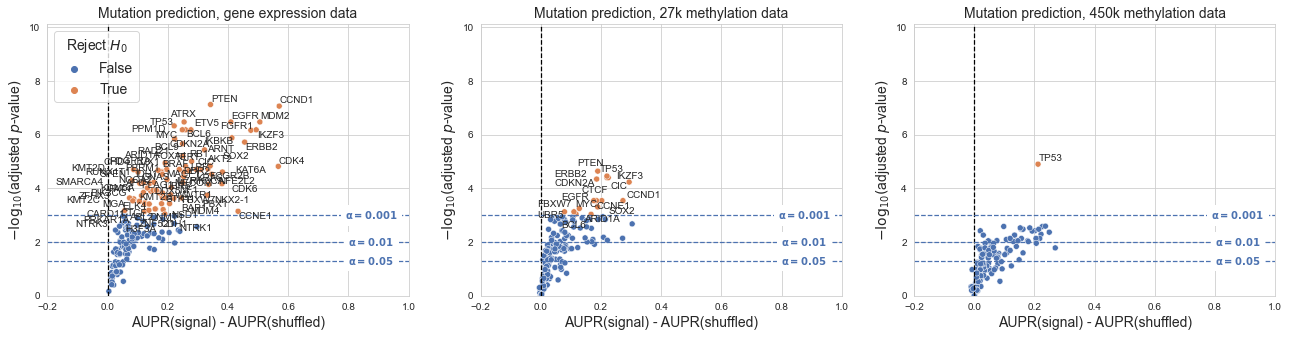

In [8]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(new_all_results_df,
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric='aupr',
                          verbose=True)

RPPA: 41/182
microRNA: 25/182
mutational signatures: 7/182


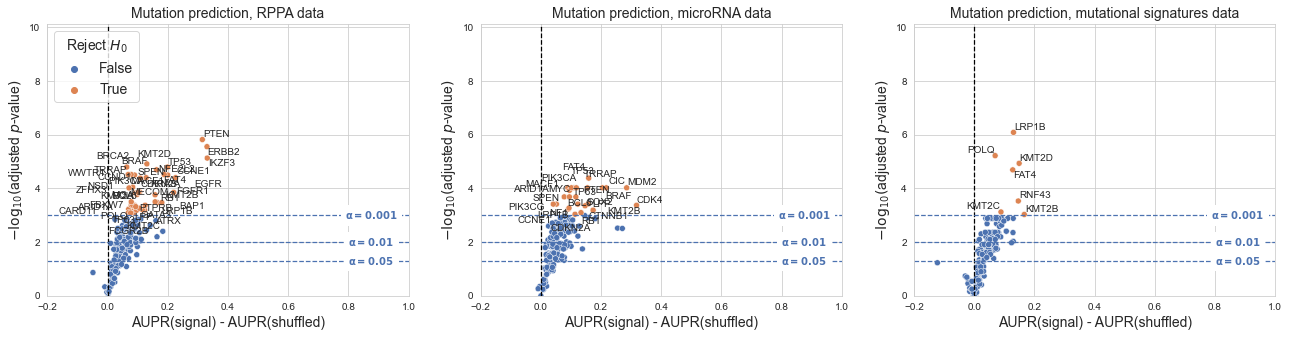

In [11]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['RPPA', 'microRNA', 'mutational signatures']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(new_all_results_df,
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric='aupr',
                          verbose=True)

### Compare against results with old filtering scheme

In [14]:
# load raw data
old_results_df = au.load_stratified_prediction_results(orig_results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
old_results_df = old_results_df[old_results_df.training_data.isin(['expression', 'rppa', 'mirna', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(old_results_df.shape)
print(old_results_df.seed.unique())
print(old_results_df.training_data.unique())
old_results_df.head()

(41376, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.89764,0.716580,MAP3K1,expression,signal,42,train,0,gene
1,0.44982,0.075833,MAP3K1,expression,signal,42,test,0,gene
2,0.66546,0.300290,MAP3K1,expression,signal,42,cv,0,gene
3,0.98281,0.909130,MAP3K1,expression,signal,42,train,1,gene
4,0.85560,0.564490,MAP3K1,expression,signal,42,test,1,gene


In [16]:
# load compressed data for me_27k and me_450k
old_compressed_results_df = au.load_compressed_prediction_results(
    orig_results_dir, 'gene')

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(old_compressed_results_df.shape)
print(old_compressed_results_df.seed.unique())
print(old_compressed_results_df.training_data.unique())
print(old_compressed_results_df.n_dims.unique())
old_compressed_results_df.head()

(20688, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.81326,0.45134,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.65695,0.28388,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.73856,0.45058,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [17]:
old_results_df['n_dims'] = 'raw'
old_results_df = pd.concat((old_results_df, old_compressed_results_df))
print(old_results_df.seed.unique())
print(old_results_df.training_data.unique())
print(old_results_df.n_dims.unique())
print(old_results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
old_results_df.training_data.replace(to_replace=training_data_map, inplace=True)
old_results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(62064, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.89764,0.716580,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.44982,0.075833,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.66546,0.300290,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.98281,0.909130,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.85560,0.564490,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [19]:
old_all_results_df = au.compare_all_data_types(old_results_df,
                                               SIG_ALPHA,
                                               metric='aupr')

old_all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
23,BRAF,0.308046,6.123121e-10,1.328717e-07,True,27k methylation,6.876567
45,CIC,0.647034,1.880651e-09,4.081014e-07,True,450k methylation,6.389232
60,ERBB2,0.312735,2.905854e-09,3.152852e-07,True,27k methylation,6.501296
45,CIC,0.645135,3.558277e-09,7.721461e-07,True,gene expression,6.112301
56,EGFR,0.531508,9.779722e-09,8.999793e-07,True,gene expression,6.045767
60,ERBB2,0.537138,1.339592e-08,8.999793e-07,True,gene expression,6.045767
168,PTEN,0.229569,1.460109e-08,1.056146e-06,True,27k methylation,5.976276
207,TSC1,0.616890,1.745741e-08,8.999793e-07,True,gene expression,6.045767
30,CCND1,0.603684,2.073685e-08,8.999793e-07,True,gene expression,6.045767
204,TP53,0.202256,3.084420e-08,6.693192e-06,True,RPPA,5.174367


In [25]:
overlap_genes = (
    set(new_all_results_df.gene.unique())
      .intersection(set(old_all_results_df.gene.unique()))
)

new_all_results_df = new_all_results_df[new_all_results_df.gene.isin(overlap_genes)]
old_all_results_df = old_all_results_df[old_all_results_df.gene.isin(overlap_genes)]

cols = ['gene', 'training_data', 'delta_mean']
diff_df = (old_all_results_df
  .loc[:, cols]
  .merge(new_all_results_df.loc[:, cols],
         left_on=['gene', 'training_data'],
         right_on=['gene', 'training_data'])
)

diff_df.rename(
    columns={'delta_mean_x': 'delta_mean_old',
             'delta_mean_y': 'delta_mean_new'},
    inplace=True
)
diff_df['old_vs_new'] = diff_df.delta_mean_old - diff_df.delta_mean_new
diff_df.head()

,gene,training_data,delta_mean_old,delta_mean_new,old_vs_new
0,ABL2,gene expression,0.157714,0.123981,0.033733
1,ACVR2A,gene expression,0.221802,0.070957,0.150845
2,AFF3,gene expression,0.099245,0.041126,0.058119
3,ALK,gene expression,0.016024,0.024287,-0.008263
4,AMER1,gene expression,-0.015359,0.015703,-0.031062
